<a href="https://colab.research.google.com/github/icsd13152/NLP_Exercises/blob/main/NLP_Exe2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import spacy
import re
import os
from nltk.probability import FreqDist
nltk.download('treebank')
from nltk.corpus import treebank
import string
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import Counter, defaultdict
from nltk.util import ngrams
from nltk.probability import FreqDist
import math
import matplotlib.pyplot as plt


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/NLP'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# N-gram Language Models

## Bigrams με add-1 smoothing

Με την μέθοδο του Add-1 smoothing, πρακτικά υπολογίσουμε την πιθανότητα του ngram προσθέτωντας +1 στο πλήθος του συγκεκριμένου ngram ώστε να μην προκύψει πιθανότητα ίση με το μηδέν. Αυτή η τεχνική ονομάζεται και Laplace smoothing. 

In [ ]:
def joinGroundTruthTokenInOneList(treebankFiles):
    tokens = list()
    for file in treebankFiles:
        tmpTokens = treebank.words(file)
        for index in range(len(tmpTokens)):
            tokens.append(tmpTokens[index])
    return tokens


def customizeTreebank(files,lookupDict):
  tokens = list()
  counter = 0
  
  for file in files:
      tmpTokens = treebank.words(file)
      for index in range(len(tmpTokens)):
        if index == 0:
          tokens.append("<BOS>")
        else:
          if lookupDict[tmpTokens[index]] < 3:
            tokens.append('<UNK>')
          else:
            tokens.append(tmpTokens[index])
      tokens.append("<EOS>")
  return tokens    
  

def customizeTest(files,listOftrainSet): 
  tokens = list()     
  for file in files:
      tmpTokens = treebank.words(file)
      for index in range(len(tmpTokens)):
          if index == 0:
            tokens.append("<BOS>")
          else:
            if tmpTokens[index] in listOftrainSet:
              tokens.append(tmpTokens[index])
            else:
              tokens.append('<UNK>')
      tokens.append("<EOS>")
  return tokens

files150 = treebank.fileids()[:150]
tokens = joinGroundTruthTokenInOneList(files150)
lookupFreqDict = FreqDist(tokens)
files = treebank.fileids()[151:len(treebank.fileids())-1]

listOfTokens150 = customizeTreebank(files150,lookupFreqDict)
listOfTokensTest = customizeTest(files,listOfTokens150)

bigramms = dict()
class BigramAdd1Smoothing(object):

    def __init__(self):
      # self.files150 = treebank.fileids()[:150]
      self.bigram_counts = defaultdict(lambda: defaultdict(int))
      self.unigram_counts = defaultdict(int)
      self.total_bigrams = 0
      self.bigrammsDict = {}
    def train(self,tokens):
      
      for i in range(1, len(tokens)):

          bigram = (tokens[i-1], tokens[i])
          # print()
          # print(bigram)
          self.bigram_counts[bigram[0]][bigram[1]] += 1
          self.unigram_counts[bigram[0]] += 1
          self.total_bigrams += 1
      


    def get_bigram_probability(self, listOfTokens):
        prob = 0.0
        for i in range(1, len(listOfTokens)):

            bigram = (listOfTokens[i-1], listOfTokens[i])
            # print(bigram)
            first_word = bigram[0]
            second_word = bigram[1]
            # if the bigram doesn't exist in our counts, then we need to
            # return the probability of the unigram
            if self.bigram_counts[first_word][second_word] == 0:
                prob =  1.0 / (self.unigram_counts[first_word] + len(self.unigram_counts))

            # otherwise, we can just return the bigram probability
            else:
                prob = 1.0 * self.bigram_counts[first_word][second_word] / self.unigram_counts[first_word]
            bigramms[bigram] = prob
            # print(bigramms)
            # if i == 10:
            #   break
        self.bigrammsDict = bigramms
        return self.bigrammsDict

modelBigramm = BigramAdd1Smoothing()

bigramsTrain = modelBigramm.train(listOfTokens150)
bigramms = modelBigramm.get_bigram_probability(listOfTokens150)

# print(modelBigramm.get_bigram_probability(bigramsTrain))


def calcPerplexity(bigrams, listOfTokens):

    perplexity = 1.000
    N = len(listOfTokens)
    prob = 1.0
    for idx in range(1,len(listOfTokens)):
        bigr = (listOfTokens[idx-1],listOfTokens[idx])
        # print(bigr)
        # print(bigrams[bi])
        if bigr in bigrams.keys():
          #  print(prob)
           prob += math.log2(bigrams[bigr])
        #      prob *= 1/(bigrams[bigr]*100)
        # else: 
        #      prob = 1
        
    
    if prob != 0.0:
      perplexity = (-prob/N)*100
      #  perplexity = prob**(1/N)
    # perplexity = pow(perplexity, 1/N)
    return perplexity

perplexityAdd1bigr = calcPerplexity(bigramms,listOfTokensTest)#listOfTokensTest
print(perplexityAdd1bigr)

  
    

350.89923705991373


## Bigrams με Good-Turing discounting

Για τον υπολογισμό της πιθανότητας του κάθε ngram με παρα πολύ χαμηλή ή μηδενική συχνότητα εμφάνισης, χρησιμοποιούμε τις πιθανότητες των ngram με υψηλότερη συχνότητα. Για παράδειγμα:
Έστω οτι έχω τα παρακάτω unigrams με συχνότητες:
* (I) = 1
* (go) = 2
* (to) = 2
* (play) =1  <br>

Για να υπολογίσω τις πιθανότητες ακολουθώ την εξής διαδικασία: <br>

Πλήθος tokens = 1 + 2 + 2 + 1 = 6 <br>
Πλήθος εμφάνησης της συχνότητας 1 (συχνότητα της συχνότητας) = 2 <br>
Άρα N1 = 2, επομένως C = N1/Πλήθος tokens = 2/6 <br>
Για την τελική  Πιθανότητα του token Ι θα πρέπει με παρόμοιο τρόπο να υπολογίσω και το αντίστοιχο C για την αμέσως επόμενη συχνότητα, δηλ. το 2.
Άρα το C* του token I = 2 * N2/N1. Εάν όλο αυτό το διαιρέσουμε με το πλήθος των tokens στο corpus τότε έχουμε την πιθανότητα που ζητάμε. 




In [ ]:
bigramms = dict()
import pandas as pd
class BigramGoodTuringSmoothing(object):

    def __init__(self):
      # self.files150 = treebank.fileids()[:150]
      self.bigram_counts = defaultdict(lambda: defaultdict(int))
      self.unigram_counts = defaultdict(int)
      self.total_bigrams = 0
      self.bigrammsDict = {}
      self.N = list()
    def train(self,tokens):
      
      for i in range(1, len(tokens)):

          bigram = (tokens[i-1], tokens[i])
          # print()
          # print(bigram)
          self.bigram_counts[bigram[0]][bigram[1]] += 1
          self.unigram_counts[bigram[0]] += 1
          self.total_bigrams += 1

    def calculateN(self,listTokens): #c = Counter(dictionary.values())
        for i in range(1, len(listTokens)):
            bigram = (listTokens[i-1], listTokens[i])
            self.N.append(self.bigram_counts[bigram[0]][bigram[1]])
        obs_count = {}
        for item in self.N:
            if item in obs_count:
               obs_count[item] += 1
            else:
               obs_count[item] = 1
        return obs_count
    def get_bigram_probability(self, listOfTokens,counts):
        prob = 0.0
        counter = 0
        for i in range(1, len(listOfTokens)):

            bigram = (listOfTokens[i-1], listOfTokens[i])
            # print(bigram)
            first_word = bigram[0]
            second_word = bigram[1]
            # Nc = self.N[self.bigram_counts[first_word][second_word]] 
            # print()
            Nc = self.N[self.bigram_counts[first_word][second_word]] 
            Nnext = Nc + 1 
            c = (self.bigram_counts[first_word][second_word] + 1) * Nnext  / Nc
            prob = c/len(self.N)
            # tmpList = sorted(list(counts))
            # # print(tmpList)      
            # Nc = counts[self.bigram_counts[first_word][second_word]]
            
            # # print(Nc)
            # # print(tmpList.index(self.bigram_counts[first_word][second_word]))
            # if tmpList.index(self.bigram_counts[first_word][second_word]) != len(tmpList)-1:
            #     Nnext = tmpList[tmpList.index(self.bigram_counts[first_word][second_word]) + 1]
            # else:
            #     Nnext = tmpList[tmpList.index(self.bigram_counts[first_word][second_word])]     
            # # print(Nnext)
            # c = (self.bigram_counts[first_word][second_word] + 1) * Nnext  / Nc
            # prob = c/len(self.N)
            # print(prob*100)
            bigramms[bigram] = prob

        self.bigrammsDict = bigramms
        return self.bigrammsDict

modelgoodTuringBigramm = BigramGoodTuringSmoothing()

bigramsTrain = modelgoodTuringBigramm.train(listOfTokens150)
counts = modelgoodTuringBigramm.calculateN(listOfTokens150)
bigramms = modelgoodTuringBigramm.get_bigram_probability(listOfTokens150,counts)

# print(modelgoodTuringBigramm.get_bigram_probability(bigramsTrain))


def calcPerplexity(bigrams, listOfTokens):

    perplexity = 1.000
    N = len(listOfTokens)
    prob = 1.0
    for idx in range(1,len(listOfTokens)):
        bigr = (listOfTokens[idx-1],listOfTokens[idx])
        # print(bigr)
        # print(bigrams[bi])
        if bigr in bigrams.keys():
          #  print(prob)
           prob += math.log2(bigrams[bigr])
        #      prob *= 1/(bigrams[bigr]*100)
        # else: 
        #      prob = 1
        
        
    
    if prob != 0.0:
       perplexity = (-prob/N)*100
      # perplexity = prob**(1/N)
    # perplexity = pow(perplexity, 1/N)
    return perplexity

perplexityGTbigr = calcPerplexity(bigramms,listOfTokensTest)#listOfTokensTest
print(perplexityGTbigr)

845.7991102413606


## Trigrams με add-1 smoothing

In [ ]:
class TrigramAdd1SmoothingModel(object):

  def __init__(self):

      self.trigram_counts = defaultdict(lambda: defaultdict(int))
      self.bigram_counts = defaultdict(lambda: defaultdict(int))
      self.unigram_counts = defaultdict(int)
      self.total_bigrams = 0
      self.trigramsDict = dict()
  def train(self,tokens):
      for i in range(2, len(tokens)):

          trigram = (tokens[i-2],tokens[i-1], tokens[i])
          # print(trigram)
          # print(bigram)
          self.trigram_counts[(trigram[0],trigram[1])][trigram[2]] += 1
          self.bigram_counts[trigram[0]][trigram[1]] += 1
          self.unigram_counts[trigram[0]] += 1
          self.total_bigrams += 1

  def get_trigram_probability(self, listOfTokens):
        prob = 0.0
        trigramms = dict()
        for i in range(1, len(listOfTokens)):

            trigram = (listOfTokens[i-2],listOfTokens[i-1], listOfTokens[i])
            # print(bigram)
            first_word = trigram[0]
            second_word = trigram[1]
            third_word = trigram[2]
            # if the bigram doesn't exist in our counts, then we need to
            # return the probability of the unigram
            if self.trigram_counts[(first_word,second_word)][third_word] == 0:
                if self.bigram_counts[first_word][second_word] == 0:
                   prob =  1.0 / (self.unigram_counts[first_word] + len(self.unigram_counts))
                else:
                   prob = 1.0 * self.bigram_counts[first_word][second_word] / self.unigram_counts[first_word]
            # otherwise, we can just return the trigram probability
            else:
                prob = 1.0 * self.trigram_counts[(first_word,second_word)][third_word] / self.bigram_counts[first_word][second_word]
            trigramms[trigram] = prob
            # print(bigramms)
            # if i == 10:
            #   break
        self.trigramsDict = trigramms
        return trigramms


modelTrigram = TrigramAdd1SmoothingModel()

trigramsTrain = modelTrigram.train(listOfTokens150)
trigramms = modelTrigram.get_trigram_probability(listOfTokens150)
print(trigramms)

def calcPerplexity(trigramms, listOfTokens):

    perplexity = 1.000
    N = len(listOfTokens)
    prob = 1.0
    for idx in range(2,len(listOfTokens)):
        trigr = (listOfTokens[idx-2],listOfTokens[idx-1],listOfTokens[idx])
        # print(bigr)
        # print(bigrams[bi])
        if trigr in trigramms.keys():
          #  print(prob)
           prob += math.log2(trigramms[trigr])
        #      prob *= 1/ (trigramms[trigr] * 100)
        
        # else: 
        #      prob = 1
        
        
    
    if prob != 0.0:
       perplexity = (-prob/N)*100
      # perplexity = prob**(1/N)
    # perplexity = pow(perplexity, 1/N)
    return perplexity

perpltrigrAdd1 = calcPerplexity(trigramms,listOfTokensTest)
print(perpltrigrAdd1)

{('<EOS>', '<BOS>', '<UNK>'): 0.22818791946308725, ('<BOS>', '<UNK>', ','): 0.17142857142857143, ('<UNK>', ',', '61'): 0.0010224948875255625, (',', '61', 'years'): 1.0, ('61', 'years', 'old'): 1.0, ('years', 'old', ','): 0.5555555555555556, ('old', ',', 'will'): 0.2, (',', 'will', 'join'): 0.05263157894736842, ('will', 'join', 'the'): 1.0, ('join', 'the', 'board'): 0.5, ('the', 'board', 'as'): 0.18181818181818182, ('board', 'as', 'a'): 1.0, ('as', 'a', 'nonexecutive'): 0.044444444444444446, ('a', 'nonexecutive', 'director'): 1.0, ('nonexecutive', 'director', 'Nov.'): 0.25, ('director', 'Nov.', '29'): 1.0, ('Nov.', '29', '.'): 0.5, ('29', '.', 'Mr.'): 1.0, ('.', 'Mr.', '<UNK>'): 0.19101123595505617, ('Mr.', '<UNK>', 'is'): 0.09803921568627451, ('<UNK>', 'is', 'chairman'): 0.014705882352941176, ('is', 'chairman', 'of'): 1.0, ('chairman', 'of', '<UNK>'): 0.35294117647058826, ('of', '<UNK>', 'N.V.'): 0.007874015748031496, ('<UNK>', 'N.V.', ','): 0.6666666666666666, ('N.V.', ',', 'the'): 0.

## Trigrams με Good-Turing discounting

In [ ]:
class TrigramGoodTuringSmoothingModel(object):

  def __init__(self):

      self.trigram_counts = defaultdict(lambda: defaultdict(int))
      self.bigram_counts = defaultdict(lambda: defaultdict(int))
      self.unigram_counts = defaultdict(int)
      self.total_bigrams = 0
      self.N = list()
      self.trigramsDict = dict()
  def train(self,tokens):
      for i in range(2, len(tokens)):

          trigram = (tokens[i-2],tokens[i-1], tokens[i])
          # print(trigram)
          # print(bigram)
          self.trigram_counts[(trigram[0],trigram[1])][trigram[2]] += 1
          self.bigram_counts[trigram[0]][trigram[1]] += 1
          self.unigram_counts[trigram[0]] += 1
          self.total_bigrams += 1

  def calculateN(self,listTokens): 
        for i in range(1, len(listTokens)):
            trigram = (listTokens[i-2],listTokens[i-1], listTokens[i])
            first_word = trigram[0]
            second_word = trigram[1]
            third_word = trigram[2]
            self.N.append(self.trigram_counts[(first_word,second_word)][third_word])
        obs_count = {}
        for item in self.N:
            if item in obs_count:
               obs_count[item] += 1
            else:
               obs_count[item] = 1
        return obs_count
  def get_trigram_probability(self, listOfTokens):
        prob = 0.0
        trigramms = dict()
        for i in range(1, len(listOfTokens)):

            trigram = (listOfTokens[i-2],listOfTokens[i-1], listOfTokens[i])
            # print(bigram)
            first_word = trigram[0]
            second_word = trigram[1]
            third_word = trigram[2]
            Nc = self.N[self.trigram_counts[(trigram[0],trigram[1])][trigram[2]]] 
            Nnext = Nc + 1 
            c = (self.trigram_counts[(trigram[0],trigram[1])][trigram[2]] + 1) * Nnext  / Nc
            prob = c/len(self.N)
            trigramms[trigram] = prob
        self.trigramsDict = trigramms
        return trigramms


modelTrigramGoodTuring = TrigramGoodTuringSmoothingModel()

trigramsTrain = modelTrigramGoodTuring.train(listOfTokens150)
modelTrigramGoodTuring.calculateN(listOfTokens150)
trigramms = modelTrigramGoodTuring.get_trigram_probability(listOfTokens150)

def calcPerplexity(trigramms, listOfTokens):

    perplexity = 0
    N = len(listOfTokens)
    prob = 0
    for idx in range(2,len(listOfTokens)):
        trigr = (listOfTokens[idx-2],listOfTokens[idx-1],listOfTokens[idx])
        # print(bigr)
        # print(bigrams[bi])
        if trigr in trigramms.keys():
          #  print(prob)
           prob += math.log2(trigramms[trigr])
        
    
    if prob != 0.0:
       perplexity = (-prob/N)*100
    # perplexity = pow(perplexity, 1/N)
    return perplexity
perpltrigrGT = calcPerplexity(trigramms,listOfTokensTest)
print(perpltrigrGT)

514.7967908727604


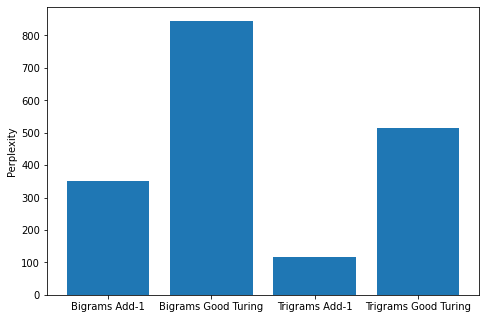

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Bigrams Add-1', 'Bigrams Good Turing', 'Trigrams Add-1', 'Trigrams Good Turing']
ppls = [perplexityAdd1bigr,perplexityGTbigr,perpltrigrAdd1,perpltrigrGT]
ax.bar(models,ppls)
ax.set_ylabel('Perplexity')
plt.show()

Αφου δημιουργήσαμε τα n-grams μοντέλα μας και αφού τα αξιολογήσαμε με βάση το perplexity στο test set, προκύτπει το παραπάνω bar plot. Σύμφωνα με αυτό θα πρέπει να επιλέξουμε το χαμηλότερο perplexity, καθώς αυτή η μετρική μας δείχνει πόσο καλά είναι πεπεισμένο ένα μοντέλο για την εκάστοτε πρόβλεψή του.
Δηλαδή αντιστοιχεί στην ανάστροφη πιθανότητα. 
Επομένως για να κάνουμε generate προτάσεις θα μπορούσε κανείς να επιλέξει το Trigrams Add-1 smoothing. Πράγμα το οποίο είναι λογικό, διότι όσο πιο πολλά n-grams έχουμε τόσο ανεβαίνει και η απόδοση του μοντέλου. Εάν είχαμε πιο πολλά δεδομένα πιθανώς να μπορούσαμε να μειώσουμε την τιμή του perplexity, καθώς θα είχαμε μεγαλύτερες συχνότητες.

## Generate Text

In [ ]:
import random
import pandas as pd
def generate_text(model, num_words):
    myDict = dict()
    
    indicator = 0
    if isinstance(model, BigramAdd1Smoothing):
       myDict = model.bigrammsDict
       indicator = 0
    elif isinstance(model, BigramGoodTuringSmoothing):
       myDict = model.bigrammsDict
       indicator = 1
    elif isinstance(model, TrigramAdd1SmoothingModel):
       myDict = model.trigramsDict
       indicator = 2
    elif isinstance(model, TrigramGoodTuringSmoothingModel):
       myDict = model.trigramsDict
       indicator = 3  
    # start with a random word
    generated_text = list()
    # context = dict()
    # if indicator == 0:
    #    if len(tokens) > 1:
    #       for i in range(1,len(tokens)):
    #           bigram = (tokens[i-1],tokens[i])
    #           if i-1 == 0:              
    #              generated_text.append(('<BOS>',bigram[0]))
    #           # else:
    #           generated_text.append(bigram)
    #    else:
    #        generated_text.append(('<BOS>',tokens[0]))
    #    for ngram in generated_text:
    #        first , second = myDict[ngram]
    #        if first in context:
    #           context[first].append(second)
    #        else:
    #           context[first] = [second]
    # elif indicator == 1:
    #    if len(tokens) > 1:
    #       for i in range(1,len(tokens)):
    #           bigram = (tokens[i-1],tokens[i])
    #           if i-1 == 0:              
    #              generated_text.append(('<BOS>',bigram[0]))
              
    #           generated_text.append(bigram)
    #    else:
    #        generated_text.append(('<BOS>',tokens[0]))
    #    for ngram in generated_text:
    #        first , second = myDict[ngram]
    #        if first in context:
    #           context[first].append(second)
    #        else:
    #           context[first] = [second]
    # elif indicator == 2:
    #    if len(tokens) > 2:
    #       for i in range(2,len(tokens)):
    #           trigram = (tokens[i-2],tokens[i-1],tokens[i])
    #           if i-2 == 0:              
    #              generated_text.append(('<BOS>',trigram[0],trigram[1]))
              
    #           generated_text.append(trigram)
    #    else:
    #        generated_text.append(('<BOS>',tokens[0]))
    #        generated_text.append((tokens[0],tokens[1]))
    #   #  for ngram in generated_text:
    #   #      if ngram in myDict.keys():
    #   #         first , second,third = myDict[ngram]
    #   #         if first in context:
    #   #             context[(first,second)].append(third)
    #   #         else:
    #   #             context[(first,second)] = [third]
    # elif indicator == 3:
    #    if len(tokens) > 2:
    #       for i in range(2,len(tokens)):
    #           trigram = (tokens[i-2],tokens[i-1],tokens[i])
    #           if i-2 == 0:              
    #              generated_text.append(('<BOS>',trigram[0],trigram[1]))
              
    #           generated_text.append(trigram)
    #    else:
    #        generated_text.append(('<BOS>',tokens[0]))
    #        generated_text.append((tokens[0],tokens[1]))
    #    for ngram in generated_text:
    #        first , second,third = myDict[ngram]
    #        if first in context:
    #           context[(first,second)].append(third)
    #        else:
    #           context[(first,second)] = [third]
    # print(generated_text)
    current_word = random.choice(list(myDict))
    
    
    current_word = '<BOS>' + ' ' +current_word[0]+ ' ' +current_word[1]  + ' ' +current_word[2]
    generated_text.append(current_word)
   
    # add num_words words to the generated text
    
    for i in range(0,num_words):
        # if current_word.endswith('<EOS>'):
        #    break
        maxProb = 0.0
        current_word = generated_text[i]
        # # get a list of all possible next words
        tmp_cur_words =  current_word.split()
        next_word = ""
        prev_word = current_word[len(current_word)-1]
        for ngram in myDict.keys():
            # print(ngram)
            # prev_word =
            if myDict[ngram] >= maxProb:

               maxProb = myDict[ngram]
                  
               next_word = ngram[0] + ' '+ ngram[1] + ' '+ngram[2]
              #  myDict.pop(ngram) 
                  # print(next_word)
               prev_word = next_word
                  # break

        # append the next word to the generated text
        generated_text.append(next_word)

        # update the current word
        current_word = next_word
        # print(current_word)
    generated_text.append('<EOS>')
    return ' '.join(generated_text)

 

text = generate_text(modelTrigram,15)
print(text)

<BOS> n't decided whether <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <UNK> certain of <EOS>


# Character-based Language Models


## ADD-1 Smoothing 3-gram Model

In [ ]:
path = base_path + '/assignment1textfiles/sbd'
class Trigram_ADD1Model(object):
 
    def __init__(self):
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.trigramsDict = dict()
        self.trigramsDictVal = dict()
        self.X_train = list()
        self.X_val = list()

    def readData(self):
        tmpX_train = list()
        tmpX_val = list()
        tmpX_test = list()
        listDocsSpacyEL = list()
        lookupDict = {'@':0,'~':1}
        for file in os.listdir(path)[:10]: #train
            if file.endswith(".TXT"):
                file_path = f"{path}/{file}"
                with open(file_path , 'r',encoding = 'utf-8') as f:
                    tmpX_train.append(f.read().split('\n'))

        x = list()
        for tokensList in tmpX_train:
            
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   for c in range(2,len(chars)):
                       # print(chars)
                       x.append(chars[c-2])
                       x.append(chars[c-1])
                       x.append(chars[c])
        frequenies = FreqDist(x)
        for tokensList in tmpX_train:          
             for c in range(2,len(chars)):
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   if frequenies[chars[c-2]] > 5:   
                      chars[c-2] = '*'
                   if frequenies[chars[c-1]] > 5:   
                      chars[c-1] = '*'
                   if frequenies[chars[c]] > 5:
                      chars[c]  = '*'

                   self.X_train.append(((chars[c-2].lower(), chars[c-1].lower()),chars[c].lower()) ) 

        for file in os.listdir(path)[10:12]: #validation
              if file.endswith(".TXT"):
                  file_path = f"{path}/{file}"
                  with open(file_path , 'r',encoding = 'utf-8') as f:
                      tmpX_val.append(f.read().split('\n'))

        
        for tokensList in tmpX_val:
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                    
                    chars = list(token)
                    chars.insert(0,'@')
                    chars.append('~')
                
                    for c in range(2,len(chars)):
                        if chars[c-2] not in x:
                           chars[c-2] = '*'
                        if chars[c-1] not in x:
                           chars[c-1] = '*'
                        if chars[c] not in x:
                           chars[c] = '*'
                        self.X_val.append(((chars[c-2].lower(), chars[c-1].lower()),chars[c].lower()) ) 

        # X_val.append(x)
    def train(self):
        for ngram in self.X_train:
            values, label = ngram
            self.trigram_counts[values][label] += 1
            self.bigram_counts [values[0]][values[1]] += 1
            self.unigram_counts[values[0]] += 1

    def get_trigram_probability(self,data,evaluation = False):
        prob = 0.0
        trigramms = dict()
        for ngram in data:

            values, label = ngram
            # print(bigram)
            first_char = values[0]
            second_char = values[1]
            third_char = label
            # if the bigram doesn't exist in our counts, then we need to
            # return the probability of the unigram
            if self.trigram_counts[(first_char,second_char)][third_char] == 0:
                if self.bigram_counts[first_char][second_char] == 0:
                   prob =  1.0 / (self.unigram_counts[first_char] + len(self.unigram_counts))
                else:
                   prob = 1.0 * self.bigram_counts[first_char][second_char] / self.unigram_counts[first_char]
            # otherwise, we can just return the trigram probability
            else:
                prob = 1.0 * self.trigram_counts[(first_char,second_char)][third_char] / self.bigram_counts[first_char][second_char]
            trigramms[ngram] = prob
            # print(bigramms)
            # if i == 10:
            #   break
        if evaluation == False:
           self.trigramsDict = trigramms
        else:
           self.trigramsDictVal = trigramms
        # return trigramms   
        

def calcPerplexity(model,trigram_dict):
   
    y_pred = list()
    y_true = list()
    
    perplexity = 1000.0
    count = 0
    
    probabilityMult = 0.00
    count = 0
    for ngram in trigram_dict:
        # print("prob = ",model.trigramsDict[ngram])
        if (trigram_dict[ngram] != 0):

           probabilityMult += math.log2(trigram_dict[ngram])
        #    count += 1
        # else:
        #    probabilityMult *=  0.001 #something too low 
  
    if probabilityMult != 0.0:
      perplexity = (-probabilityMult/len(model.X_val))*100

    return perplexity

trigrammodeladd1 = Trigram_ADD1Model()
trigrammodeladd1.readData()
trigrammodeladd1.train()
trigrammodeladd1.get_trigram_probability(trigrammodeladd1.X_train)
trigrammodeladd1.get_trigram_probability(trigrammodeladd1.X_val,True)
perplexitytriadd1 = calcPerplexity(trigrammodeladd1,trigrammodeladd1.trigramsDictVal)
print(perplexitytriadd1)


136.7202179767641


## Good Turing Discount 3-gram Model

In [ ]:
path = base_path + '/assignment1textfiles/sbd'
class Trigram_GoodTuringSmoothingModel(object):
 
    def __init__(self):
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.trigramsDict = dict()
        self.trigramsDictVal = dict()
        self.X_train = list()
        self.X_val = list()
        self.N = list()
        self.Nval = list()

    def readData(self):
        tmpX_train = list()
        tmpX_val = list()
        tmpX_test = list()
        listDocsSpacyEL = list()
        lookupDict = {'@':0,'~':1}
        for file in os.listdir(path)[:10]: #train
            if file.endswith(".TXT"):
                file_path = f"{path}/{file}"
                with open(file_path , 'r',encoding = 'utf-8') as f:
                    tmpX_train.append(f.read().split('\n'))

        
        x = list()
        for tokensList in tmpX_train:
            
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   for c in range(2,len(chars)):
                       # print(chars)
                       x.append(chars[c-2])
                       x.append(chars[c-1])
                       x.append(chars[c])
        frequenies = FreqDist(x)
        for tokensList in tmpX_train:          
             for c in range(2,len(chars)):
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   if frequenies[chars[c-2]] > 5:   
                      chars[c-2] = '*'
                   if frequenies[chars[c-1]] > 5:   
                      chars[c-1] = '*'
                   if frequenies[chars[c]] > 5:
                      chars[c]  = '*'

                   self.X_train.append(((chars[c-2].lower(), chars[c-1].lower()),chars[c].lower()) ) 
        
        for file in os.listdir(path)[10:12]: #validation
              if file.endswith(".TXT"):
                  file_path = f"{path}/{file}"
                  with open(file_path , 'r',encoding = 'utf-8') as f:
                      tmpX_val.append(f.read().split('\n'))

        
        for tokensList in tmpX_val:
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                    
                    chars = list(token)
                    chars.insert(0,'@')
                    chars.append('~')
                
                    for c in range(2,len(chars)):
                        if chars[c-2] not in x:
                           chars[c-2] = '*'
                        if chars[c-1] not in x:
                           chars[c-1] = '*'
                        if chars[c] not in x:
                           chars[c] = '*'
                        self.X_val.append(((chars[c-2].lower(), chars[c-1].lower()),chars[c].lower()) )
        
    def train(self):
        for ngram in self.X_train:
            values, label = ngram
            self.trigram_counts[values][label] += 1
            self.bigram_counts [values[0]][values[1]] += 1
            self.unigram_counts[values[0]] += 1

    def calculateN(self,data,evaluation = False): 
        for ngram in data:
            values, label = ngram
            first_char = values[0]
            second_char = values[1]
            third_char = label
            if evaluation == False:
               self.N.append(self.trigram_counts[(first_char,second_char)][third_char])
            else:
               self.N.append(self.trigram_counts[(first_char,second_char)][third_char])
            
               
        obs_count = {}
        for item in self.N:
            if item in obs_count:
               obs_count[item] += 1
            else:
               obs_count[item] = 1
        return obs_count
    def get_trigram_probability(self,data, obs_count,evaluate = False): #obs_count as arg
        prob = 0.0
        trigramms = dict()
        for ngram in data:

            values, label = ngram
            # print(bigram)
            first_char = values[0]
            second_char = values[1]
            third_char = label
            Nc = obs_count[self.trigram_counts[(first_char,second_char)][third_char]] 
            Nnext = Nc + 1 
            c = (self.trigram_counts[(first_char,second_char)][third_char] + 1) * Nnext  / Nc
            prob = c/len(self.N)
            trigramms[ngram] = prob
        if evaluate == False:    
           self.trigramsDict = trigramms
        else:
           self.trigramsDictVal = trigramms
        return trigramms

        

def calcPerplexity(model,diction):
   
    y_pred = list()
    y_true = list()
    
    perplexity = 1000.0
    count = 0
    
    probabilityMult = 1.00
    count = 0
    for ngram in diction:
        # print("prob = ",model.trigramsDict[ngram])
        if (diction[ngram] != 0):

           probabilityMult += math.log2(diction[ngram])
        #    count += 1
        # else:
        #    probabilityMult *=  0.001 #something too low 
  
    if probabilityMult != 0.0:
      perplexity = (-probabilityMult/len(model.X_val))*100

    return perplexity

trigrammodelGT = Trigram_GoodTuringSmoothingModel()
trigrammodelGT.readData()
trigrammodelGT.train()
tr = trigrammodelGT.calculateN(trigrammodelGT.X_train)
val = trigrammodelGT.calculateN(trigrammodelGT.X_val,True)
t = trigrammodelGT.get_trigram_probability(trigrammodelGT.X_train,tr)
t2 = trigrammodelGT.get_trigram_probability(trigrammodelGT.X_val,val,True)
perplexitytriGT = calcPerplexity(trigrammodelGT,t2)
print(perplexitytriGT)

341.3809344142894


## 4-grams με Add-1 Smoothing

In [ ]:
path = base_path + '/assignment1textfiles/sbd'
class Fourgram_ADD1Model(object):
 
    def __init__(self):
        self.fourgram_counts = defaultdict(lambda: defaultdict(int))
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.fourgramsDict = dict()
        self.X_train = list()
        self.X_val = list()

    def readData(self):
        tmpX_train = list()
        tmpX_val = list()
        tmpX_test = list()
        # lookupDict = {'@':0,'~':1}
        for file in os.listdir(path)[:10]: #train
            if file.endswith(".TXT"):
                file_path = f"{path}/{file}"
                with open(file_path , 'r',encoding = 'utf-8') as f:
                    tmpX_train.append(f.read().split('\n'))

        
        x = list()
        for tokensList in tmpX_train:
            
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   for c in range(3,len(chars)):
                       # print(chars)
                       x.append(chars[c-3])
                       x.append(chars[c-2])
                       x.append(chars[c-1])
                       x.append(chars[c])
        frequenies = FreqDist(x)
        for tokensList in tmpX_train:          
             for c in range(3,len(chars)):
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   if frequenies[chars[c-3]] > 5:
                      chars[c-3] = '*'
                   if frequenies[chars[c-2]] > 5:   
                      chars[c-2] = '*'
                   if frequenies[chars[c-1]] > 5:   
                      chars[c-1] = '*'
                   if frequenies[chars[c]] > 5:
                      chars[c]  = '*'

 
                   self.X_train.append(((chars[c-3],chars[c-2].lower(), chars[c-1].lower()),chars[c].lower()) )
        for file in os.listdir(path)[10:12]: #validation
              if file.endswith(".TXT"):
                  file_path = f"{path}/{file}"
                  with open(file_path , 'r',encoding = 'utf-8') as f:
                      tmpX_val.append(f.read().split('\n'))

        
        for tokensList in tmpX_val:
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                    
                    chars = list(token)
                    chars.insert(0,'@')
                    chars.append('~')
                
                    for c in range(3,len(chars)):
                        if chars[c-3] not in x:
                           chars[c-3] = '*'
                        if chars[c-2] not in x:
                           chars[c-2] = '*'
                        if chars[c-1] not in x:
                           chars[c-1] = '*'
                        if chars[c] not in x:
                           chars[c] = '*'
                        self.X_val.append(((chars[c-3].lower(), chars[c-2].lower(),chars[c-1].lower()),chars[c].lower()) ) 
        
    def train(self):
        for ngram in self.X_train:
            values, label = ngram
            self.fourgram_counts[values][label] += 1
            self.trigram_counts[(values[0],values[1])][values[2]] += 1
            self.bigram_counts [values[0]][values[1]] += 1
            self.unigram_counts[values[0]] += 1

    def get_fourgram_probability(self,data,evaluation=False):
        prob = 0.0
        fourgramms = dict()
        for ngram in data:

            values, label = ngram
            # print(bigram)
            first_char = values[0]
            second_char = values[1]
            third_char = values[2]
            fourth_char = label
       
            if self.fourgram_counts[(first_char,second_char,third_char)][fourth_char] == 0:
                if self.trigram_counts[(first_char,second_char)][third_char] == 0:
                   if self.bigram_counts[first_char][second_char] == 0:
                      prob =  1.0 / (self.unigram_counts[first_char] + len(self.unigram_counts))
                   else:
                      prob = 1.0 * self.bigram_counts[first_char][second_char] / self.unigram_counts[first_char]
                else:
                   prob = 1.0 * self.trigram_counts[(first_char,second_char)][third_char] / self.bigram_counts[first_char][second_char]
            else:
                prob = 1.0 * self.fourgram_counts[(first_char,second_char,third_char)][fourth_char] / self.trigram_counts[(first_char,second_char)][third_char]
            fourgramms[ngram] = prob
        if evaluation == False:
           self.fourgramsDict = trigramms
        else:
           self.fourgramsDict = trigramms
        # self.fourgramsDict = fourgramms
        return fourgramms   
        

def calcPerplexity(model,dictio):
    
    perplexity = 1000.0
    count = 0
    
    probabilityMult = 0.00
    count = 0
    for ngram in dictio:
        # print("prob = ",model.trigramsDict[ngram])
        if (dictio[ngram] != 0):

           probabilityMult += math.log2(dictio[ngram])
        #    count += 1
        # else:
        #    probabilityMult *=  0.001 #something too low 
  
    if probabilityMult != 0.0:
      perplexity = (-probabilityMult/len(model.X_val))*100

    return perplexity

fourgrammodeladd1 = Fourgram_ADD1Model()
fourgrammodeladd1.readData()
fourgrammodeladd1.train()
t = fourgrammodeladd1.get_fourgram_probability(fourgrammodeladd1.X_train)
t2 = fourgrammodeladd1.get_fourgram_probability(fourgrammodeladd1.X_val,True)
perplexityfourAdd1 = calcPerplexity(fourgrammodeladd1,t2)
print(perplexityfourAdd1)

246.46485226052195


## 4-grams με Good Turing Discount

In [ ]:
path = base_path + '/assignment1textfiles/sbd'
class Fourgram_GoodTuringModel(object):
 
    def __init__(self):
        self.fourgram_counts = defaultdict(lambda: defaultdict(int))
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.fourgramsDict = dict()
        self.X_train = list()
        self.X_val= list()
        self.N = list()

    def readData(self):
        tmpX_train = list()
        tmpX_val = list()
        tmpX_test = list()
        # lookupDict = {'@':0,'~':1}
        for file in os.listdir(path)[:10]: #train
            if file.endswith(".TXT"):
                file_path = f"{path}/{file}"
                with open(file_path , 'r',encoding = 'utf-8') as f:
                    tmpX_train.append(f.read().split('\n'))

        
                x = list()
        for tokensList in tmpX_train:
            
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   for c in range(3,len(chars)):
                       # print(chars)
                       x.append(chars[c-3])
                       x.append(chars[c-2])
                       x.append(chars[c-1])
                       x.append(chars[c])
        frequenies = FreqDist(x)
        for tokensList in tmpX_train:          
             for c in range(3,len(chars)):
                token = token.replace("\xad",'-')
                if len(token) > 4:
                   chars = list(token)
                   chars.insert(0,'@')
                   chars.append('~')
                   if frequenies[chars[c-3]] > 5:
                      chars[c-3] = '*'
                   if frequenies[chars[c-2]] > 5:   
                      chars[c-2] = '*'
                   if frequenies[chars[c-1]] > 5:   
                      chars[c-1] = '*'
                   if frequenies[chars[c]] > 5:
                      chars[c]  = '*'

 
                   self.X_train.append(((chars[c-3],chars[c-2].lower(), chars[c-1].lower()),chars[c].lower()) )
        for file in os.listdir(path)[10:12]: #validation
              if file.endswith(".TXT"):
                  file_path = f"{path}/{file}"
                  with open(file_path , 'r',encoding = 'utf-8') as f:
                      tmpX_val.append(f.read().split('\n'))

        
        for tokensList in tmpX_val:
            for token in tokensList:
                # x = list()
                token = token.replace("\xad",'-')
                if len(token) > 4:
                    
                    chars = list(token)
                    chars.insert(0,'@')
                    chars.append('~')
                
                    for c in range(3,len(chars)):
                        if chars[c-3] not in x:
                           chars[c-3] = '*'
                        if chars[c-2] not in x:
                           chars[c-2] = '*'
                        if chars[c-1] not in x:
                           chars[c-1] = '*'
                        if chars[c] not in x:
                           chars[c] = '*'
                        self.X_val.append(((chars[c-3].lower(), chars[c-2].lower(),chars[c-1].lower()),chars[c].lower()) )    
    def train(self):
        for ngram in self.X_train:
            values, label = ngram
            self.fourgram_counts[values][label] += 1
            self.trigram_counts[(values[0],values[1])][values[2]] += 1
            self.bigram_counts [values[0]][values[1]] += 1
            self.unigram_counts[values[0]] += 1

    def calculateN(self,data): 
        for ngram in data:
            values, label = ngram
            first_char = values[0]
            second_char = values[1]
            third_char = values[2]
            fourth_char = label
            self.N.append(self.fourgram_counts[(first_char,second_char,third_char)][fourth_char])
        obs_count = {}
        for item in self.N:
            if item in obs_count:
               obs_count[item] += 1
            else:
               obs_count[item] = 1
        return obs_count
    def get_fourgram_probability(self,data,obs_count, evaluation=False):
        prob = 0.0
        fourgramms = dict()
        for ngram in data:

            values, label = ngram
            # print(bigram)
            first_char = values[0]
            second_char = values[1]
            third_char = values[2]
            fourth_char = label
            Nc = obs_count[self.fourgram_counts[(first_char,second_char,third_char)][fourth_char]] 
            Nnext = Nc + 1 
            c = (self.fourgram_counts[(first_char,second_char,third_char)][fourth_char] + 1) * Nnext  / Nc
            prob = c/len(self.N)
            fourgramms[ngram] = prob
        self.fourgramsDict = fourgramms
        return fourgramms
        

def calcPerplexity(model,dictio):

    perplexity = 1000.0
    count = 0
    
    probabilityMult = 0.00
    count = 0
    for ngram in dictio:
        # print("prob = ",model.trigramsDict[ngram])
        if (dictio[ngram] != 0):

           probabilityMult += math.log2(dictio[ngram])
        #    count += 1
        # else:
        #    probabilityMult *=  0.001 #something too low 
  
    if probabilityMult != 0.0:
      perplexity = (-probabilityMult/len(model.X_val))*100

    return perplexity

fourgrammodelGT = Fourgram_GoodTuringModel()
fourgrammodelGT.readData()
fourgrammodelGT.train()
tr = fourgrammodelGT.calculateN(fourgrammodelGT.X_train)
val = fourgrammodelGT.calculateN(fourgrammodelGT.X_val)
t = fourgrammodelGT.get_fourgram_probability(fourgrammodelGT.X_train,tr)
t2 = fourgrammodelGT.get_fourgram_probability(fourgrammodelGT.X_val,val,True)

perplexityfourGT = calcPerplexity(fourgrammodelGT,t2)
print(perplexityfourGT)

610.9212997670903


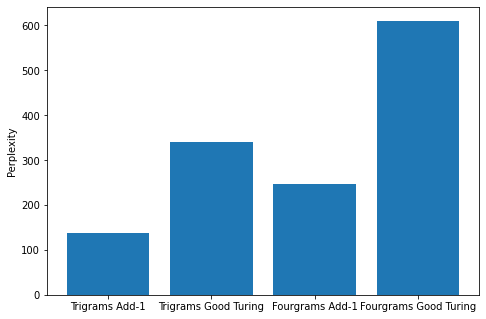

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Trigrams Add-1', 'Trigrams Good Turing', 'Fourgrams Add-1', 'Fourgrams Good Turing']
ppls = [perplexitytriadd1,perplexitytriGT,perplexityfourAdd1,perplexityfourGT]
ax.bar(models,ppls)
ax.set_ylabel('Perplexity')
plt.show()

Απο τα παραπάνω Plots καταλαβαίνουμε, οτι το καλύτερο μοντέλο είναι το Trigrams-Add-1.

# Neural Language Models

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
# from torch.nn.utils.rnn import pad_sequence
# import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
# from sklearn.metrics import 
import math
from sklearn.metrics import f1_score

## Pre-processing tokens

Αρχικά θα επεξεργαστούμε τα tokens που διαθέτουμε ώστε να να τα μετατρέψουμε σε απλούς αριθμούς για να μπορέσουμε μετά να δημιουργήσουμε Tensor, το οποίο θα μπεί ως είσοδος στο εκάστοτε νευρωνικό δίκτυο. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tmpX_train = list()
tmpX_val = list()
tmpX_test = list()
listDocsSpacyEL = list()
lookupDict = {'@':0,'~':1}
for file in os.listdir(path)[:8]: #train
    if file.endswith(".TXT"):
         file_path = f"{path}/{file}"
         with open(file_path , 'r',encoding = 'utf-8') as f:
             tmpX_train.append(f.read().split('\n'))

X_train = list()
for tokensList in tmpX_train:
    
    for token in tokensList:
        # x = list()
        token = token.replace("\xad",'-')

        X_train.append('@'+token.lower()+'~')

print(X_train[0:10])
vocb = {'α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','σ',
        'ς','τ','υ','φ','χ','ψ','ω','ί','ϊ','ΐ','ό','ά','έ','ύ','ϋ','ΰ','ή','ώ','%',';','.','!',':','-',
        '(',')',',','>','<','0','1','2','3','4','5','6','7','8','9','@','~','«','»',"'",'/','·','"',
        'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'}
char_to_idx = {char: i for i, char in enumerate(vocb)}
idx_to_char = {char_to_idx[char]: char for char in char_to_idx}
print(char_to_idx)
# y_train = to_categorical(y_train,len(x_train))


for file in os.listdir(path)[8:10]: #validation
    if file.endswith(".TXT"):
         file_path = f"{path}/{file}"
         with open(file_path , 'r',encoding = 'utf-8') as f:
             tmpX_val.append(f.read().split('\n'))

X_val = list()
for tokensList in tmpX_val:
    for token in tokensList:
        # x = list()
        token = token.replace("\xad",'-')
        X_val.append('@'+token.lower()+'~')
        # X_val.append(x)

for file in os.listdir(path)[10:12]: #validation
    if file.endswith(".TXT"):
         file_path = f"{path}/{file}"
         with open(file_path , 'r',encoding = 'utf-8') as f:
             tmpX_test.append(f.read().split('\n'))

            
X_test = list()
for tokensList in tmpX_test:
    for token in tokensList:
        # x = list()
        token = token.replace("\xad",'-')
        X_test.append('@'+token.lower()+'~')

['@αυτες~', '@τις~', '@άγιες~', '@μέρες~', '@οι~', '@άνθρωποι~', '@γιορτάζουν~', '@απολαμβάνοντας~', '@τα~', '@αγαθά~']
{'α': 0, '6': 1, 's': 2, 'ά': 3, ':': 4, '9': 5, 'ρ': 6, 'ό': 7, 'v': 8, 'θ': 9, 'ι': 10, 'i': 11, 'ΐ': 12, '.': 13, '<': 14, '7': 15, 'γ': 16, '1': 17, 'ε': 18, 'a': 19, 'x': 20, 'e': 21, 'n': 22, '8': 23, 'ϊ': 24, ',': 25, '0': 26, 'y': 27, '5': 28, 'k': 29, '!': 30, 'c': 31, 'd': 32, 'χ': 33, 'p': 34, '/': 35, '~': 36, ';': 37, 't': 38, '@': 39, '%': 40, '>': 41, 'έ': 42, 'π': 43, 'ΰ': 44, "'": 45, 'r': 46, '»': 47, 'q': 48, 'μ': 49, 'δ': 50, 'ς': 51, 'ξ': 52, 'z': 53, 'β': 54, '4': 55, '·': 56, 'ί': 57, 'τ': 58, 'o': 59, 'ύ': 60, '3': 61, 'w': 62, 'ή': 63, 'j': 64, 'm': 65, 'ώ': 66, 'φ': 67, ')': 68, 'ω': 69, 'κ': 70, '(': 71, '2': 72, 'ψ': 73, 'υ': 74, 'ζ': 75, 'h': 76, 'u': 77, 'λ': 78, 'σ': 79, 'ν': 80, 'η': 81, '"': 82, '-': 83, 'ο': 84, 'ϋ': 85, '«': 86, 'g': 87, 'b': 88, 'l': 89, 'f': 90}


Όπως θα δούμε απο το output εφόσον έχουμε μοντέλα σε επίπεδο χαρακτήρα, θα πρέπει να αντιστοιχήσουμε τον εκάστοτε χαρακτήρα σε έναν αριθμό. Για αυτό τον λόγο φτιάξαμε ένα lookup dictionary όπου θα αποτελεί το λεξικό μας για να μπορέσουμε να κάνουμε και την ανάποδη διαδικασία κατα το prediction. 

## Feedforward NN

In [ ]:
class Net(nn.Module):
   def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.emb = nn.Embedding(input_size,hidden_size).to(device)
        self.fw = nn.Linear(num_layers,output_size).to(device)
        # self.hiddenLayer = nn.Linear(hidden_size,output_size).to(device)
        self.activation_func = nn.Softmax()

        
   def forward(self, x):
        # print(x.shape)
        x = self.emb(x)
        # print(x.shape)
        x = x.view(1,-1)
        # x = x.unsqueeze(-3)
        x= self.fw(x)
   
        # x = self.fw(x.reshape(x.shape[0],-1))
        x = self.activation_func(x)

       
        return x 

  #  def init_hidden(self, batch_size):
  #      hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
  #     #  cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
  #      return hidden
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 - Training loss 4.51582 - | Train. PPL:  91.453 | Val. PPL:  91.441
Epoch 2 - Training loss 4.51569 - | Train. PPL:  91.441 | Val. PPL:  91.428
Epoch 3 - Training loss 4.51555 - | Train. PPL:  91.428 | Val. PPL:  91.413
Epoch 4 - Training loss 4.51539 - | Train. PPL:  91.413 | Val. PPL:  91.401
Epoch 5 - Training loss 4.51526 - | Train. PPL:  91.401 | Val. PPL:  91.389
Epoch 6 - Training loss 4.51512 - | Train. PPL:  91.389 | Val. PPL:  91.374
Epoch 7 - Training loss 4.51496 - | Train. PPL:  91.374 | Val. PPL:  91.358
Epoch 8 - Training loss 4.51478 - | Train. PPL:  91.358 | Val. PPL:  91.345
Epoch 9 - Training loss 4.51465 - | Train. PPL:  91.345 | Val. PPL:  91.329
Epoch 10 - Training loss 4.51447 - | Train. PPL:  91.329 | Val. PPL:  91.312


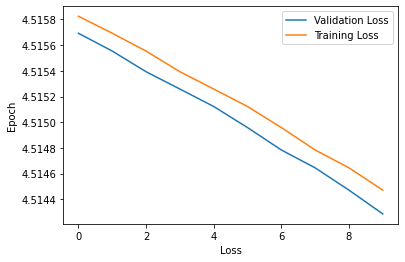

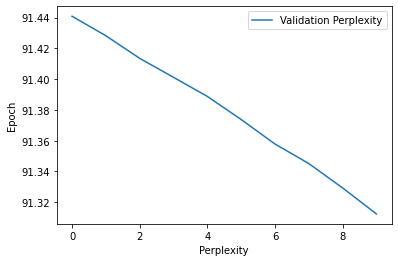

καιϋbά/μύe))5


In [ ]:
import random
import matplotlib.pyplot as plt

val_lossList = list()
train_lossList = list()
valPerplexityFW = list()
def evaluate(genereator,model,x_val,y_val,bz):
    val_loss = 0
    with torch.no_grad():
        # state = genereator.Net.init_hidden(batch_size = bz)
        for c in range(genereator.chunk_len):
            output = genereator.Net(x_val[:,c])
            val_loss += genereator.lossFunc(output,y_val[:,c])
        val_loss = val_loss.item()/genereator.chunk_len
    return val_loss
class Generator():
  def __init__(self):
      self.chunk_len = 250 #no Of chars
      self.num_epochs = 10
      self.batch_size = 1
      self.print_every = 1
      self.hidden_size = 10
      self.num_layers = 10
      self.lr = 0.001
  def char_To_tensor(self,stringValue):
      tensor = torch.zeros(len(stringValue)).long()
      # print(stringValue)
      for c in range(len(stringValue)-1):
          chars = list(stringValue[c])
          for i in chars:
              # print(i)
              tensor[c] = char_to_idx[i]
      return tensor

  def get_batch(self,data):
      start = random.randint(0,len(data)- self.chunk_len)
      end = start + self.chunk_len + 1
      text = data[start:end]
      input = torch.zeros(self.batch_size,self.chunk_len)
      target = torch.zeros(self.batch_size,self.chunk_len)
      for idx in range(self.batch_size):
          input[idx,:] = self.char_To_tensor(text[:-1])
          target[idx,:] = self.char_To_tensor(text[1:])
      return input.long(), target.long()


  def createPlot(self,valLoss,trainLoss):
      plt.plot(range(self.num_epochs),valLoss,label = 'Validation Loss')
      plt.plot(range(self.num_epochs),trainLoss,label = 'Training Loss')
      plt.legend(loc='upper right')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.show()

  def showPerplexity(self,perplexities):
      plt.plot(range(self.num_epochs),perplexities,label = 'Validation Perplexity')
      plt.legend(loc='upper right')
      plt.xlabel('Epoch')
      plt.ylabel('Perplexity')
      plt.show()

  def train(self):
    ppl_min = np.inf
    self.Net = Net(len(char_to_idx), self.hidden_size, self.num_layers,len(char_to_idx)).to(device)
    lossFunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.Net.parameters(), lr=0.001)

    for epoch in range(1,self.num_epochs +1):
        input, target = self.get_batch(X_train)
        inputVal, targetVal = self.get_batch(X_val)
        # state = self.Net.init_hidden(batch_size = self.batch_size)
        self.Net.zero_grad()
        train_loss = 0
        input = input.to(device)
        target = target.to(device)
        inputVal = input.to(device)
        targetVal = target.to(device)
        for c in range(self.chunk_len):
            
            output = self.Net(input[:,c])
            # print(output)
            # print(target[c])
            train_loss += lossFunc(output,target[:,c])
        train_loss.backward()
        optimizer.step()
        train_loss = train_loss.item()/self.chunk_len


        val_loss = evaluate(self,self.Net, inputVal,targetVal,self.batch_size)
        ppl = math.exp(val_loss)

        if ppl <= ppl_min:
            is_best = " (best) "
            # print(f1_val)
            torch.save(self.Net.state_dict(), "modelFW.pt")
            ppl_min = ppl
        else:
            is_best = ""
        valPerplexityFW.append(math.exp(val_loss))
        print(f'Epoch {epoch} - Training loss {train_loss:.5f} - | Train. PPL: {math.exp(train_loss):7.3f} | Val. PPL: {math.exp(val_loss):7.3f}')
        val_lossList.append(val_loss)
        train_lossList.append(train_loss)
    self.createPlot(val_lossList,train_lossList)
    self.showPerplexity(valPerplexityFW)
def generateText(generator,initString = 'και', pred_len = 10):
      model = Net(len(char_to_idx), generator.hidden_size, generator.num_layers,len(char_to_idx))
      model.load_state_dict(torch.load('modelFW.pt'))
      # hidden,cell = model.init_hidden(batch_size=generator.batch_size)
      init_input = generator.char_To_tensor(initString)
      predicted = initString

      for p in range(len(initString)-1):
          output = model(init_input[p].view(1).to(device))
      
      prev_char = init_input[-1]
      for p in range(pred_len):
          out = model(prev_char.view(1).to(device))
          # print(cell)
          outputProbs = out.data.view(-1)
          bestNextChar =  torch.multinomial(outputProbs,1)[0]
          predictedChar = idx_to_char[bestNextChar.item()]
          
          predicted += predictedChar
          prev_char = generator.char_To_tensor(predictedChar)

      print(predicted)

gen1 = Generator()
gen1.train()
generateText(gen1)

Όπως θα δούμε απο τα παραπάνω plots το FeedForward Net θα μπορούσε να εκπαιδευτεί καλύτερα, με κάποιο parameter tuning και για πιο πολλές εποχές. 
Αξίζει να σημειωθεί εδω οτι έγινε, ένα μικρό parameter tuning, αλλά δεν υπήρξε χρόνος για περισσότερο. Ίσως σε κάποια μελλοντική δουλειά να μπορεί να γίνει. 

## RNN

In [ ]:
class NetRNN(nn.Module):
   def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(NetRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.emb = nn.Embedding(input_size,hidden_size).to(device)
        self.rnn = nn.RNN(hidden_size,hidden_size,num_layers,batch_first=True).to(device)
        self.hiddenLayer = nn.Linear(hidden_size,output_size).to(device)
        self.activation_func = nn.Softmax()

        
   def forward(self, x,state):
        # print(x.shape)
        x = self.emb(x)
        # print(x.shape)
        # x = x.view(1,-1)
        # x = x.unsqueeze(-3)
        x,state = self.rnn(x.unsqueeze(1),state)
        print(x.shape)
        x = self.hiddenLayer(x.reshape(x.shape[0],-1))
        x = self.activation_func(x)

       
        return x , state

   def init_hidden(self, batch_size):
       hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      #  cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
       return hidden
    

In [ ]:
import random
import matplotlib.pyplot as plt

val_lossList = list()
train_lossList = list()
valPerplexityRNN = list()
def evaluate(genereator,model,x_val,y_val,bz):
    val_loss = 0
    with torch.no_grad():
        state = genereator.NetRNN.init_hidden(batch_size = bz)
        for c in range(genereator.chunk_len):
            output, state = genereator.NetRNN(x_val[:,c],state)
            val_loss += genereator.lossFunc(output,y_val[:,c])
        val_loss = val_loss.item()/genereator.chunk_len
    return val_loss
class Generator():
  def __init__(self):
      self.chunk_len = 250 #no Of chars
      self.num_epochs = 10
      self.batch_size = 1
      self.print_every = 1
      self.hidden_size = 128
      self.num_layers = 2
      self.lr = 0.001
  def char_To_tensor(self,stringValue):
      tensor = torch.zeros(len(stringValue)).long()
      # print(stringValue)
      for c in range(len(stringValue)-1):
          chars = list(stringValue[c])
          for i in chars:
              # print(i)
              tensor[c] = char_to_idx[i]
      return tensor

  def get_batch(self,data):
      start = random.randint(0,len(data)- self.chunk_len)
      end = start + self.chunk_len + 1
      text = data[start:end]
      input = torch.zeros(self.batch_size,self.chunk_len)
      target = torch.zeros(self.batch_size,self.chunk_len)
      for idx in range(self.batch_size):
          input[idx,:] = self.char_To_tensor(text[:-1])
          target[idx,:] = self.char_To_tensor(text[1:])
      return input.long(), target.long()


  def createPlot(self,valLoss,trainLoss):
      plt.plot(range(self.num_epochs),valLoss,label = 'Validation Loss')
      plt.plot(range(self.num_epochs),trainLoss,label = 'Training Loss')
      plt.legend(loc='upper right')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.show()
  def showPerplexity(self,perplexities):
      plt.plot(range(self.num_epochs),perplexities,label = 'Validation Perplexity')
      plt.legend(loc='upper right')
      plt.xlabel('Epoch')
      plt.ylabel('Perplexity')
      plt.show()

  def train(self):
    ppl_min = np.inf
    self.NetRNN = NetRNN(len(char_to_idx), self.hidden_size, self.num_layers,len(char_to_idx)).to(device)
    lossFunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.NetRNN.parameters(), lr=0.001)

    for epoch in range(1,self.num_epochs +1):
        input, target = self.get_batch(X_train)
        inputVal, targetVal = self.get_batch(X_val)
        state = self.NetRNN.init_hidden(batch_size = self.batch_size)
        self.NetRNN.zero_grad()
        train_loss = 0
        input = input.to(device)
        target = target.to(device)
        inputVal = input.to(device)
        targetVal = target.to(device)
        for c in range(self.chunk_len):
            
            output, state = self.NetRNN(input[:,c],state)
            train_loss += lossFunc(output,target[:,c])
        train_loss.backward()
        optimizer.step()
        train_loss = train_loss.item()/self.chunk_len
        # if epoch % self.print_every == 0:
        #     print(f'Train Loss: {train_loss}')

        val_loss = evaluate(self,self.NetRNN, inputVal,targetVal,self.batch_size)
        ppl = math.exp(val_loss)

        if ppl <= ppl_min:
            is_best = " (best) "
            # print(f1_val)
            torch.save(self.NetRNN.state_dict(), "modelRNN.pt")
            ppl_min = ppl
        else:
            is_best = ""
        print(f'Epoch {epoch} - Training loss {train_loss:.5f} - | Train. PPL: {math.exp(train_loss):7.3f} | Val. PPL: {math.exp(val_loss):7.3f}')
        val_lossList.append(val_loss)
        train_lossList.append(train_loss)
        valPerplexityRNN.append(math.exp(val_loss))

    self.createPlot(val_lossList,train_lossList)
    self.showPerplexity(valPerplexityRNN)
def generateText(generator,initString = 'και', pred_len = 10):
      model = NetRNN(len(char_to_idx), generator.hidden_size, generator.num_layers,len(char_to_idx))
      model.load_state_dict(torch.load('model.pt'))
      hidden,cell = model.init_hidden(batch_size=generator.batch_size)
      init_input = generator.char_To_tensor(initString)
      predicted = initString

      for p in range(len(initString)-1):
          _,(hidenn,cell) = model(init_input[p].view(1).to(device),hidden,cell)
      
      prev_char = init_input[-1]
      for p in range(pred_len):
          out,(hidenn,cell) = model(prev_char.view(1).to(device),hidden,cell)
          # print(cell)
          outputProbs = out.data.view(-1)
          bestNextChar =  torch.multinomial(outputProbs,1)[0]
          predictedChar = idx_to_char[bestNextChar.item()]
          
          predicted += predictedChar
          prev_char = generator.char_To_tensor(predictedChar)

      print(predicted)
gen1 = Generator()
gen1.train()

generateText(gen1)

torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1

AttributeError: ignored

## LSTM

In [ ]:
class NetLSTM(nn.Module):
   def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(NetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.emb = nn.Embedding(input_size,hidden_size).to(device)
        self.lstm = nn.LSTM(hidden_size,hidden_size,num_layers,batch_first=True).to(device)
        self.hiddenLayer = nn.Linear(hidden_size,output_size).to(device)
        self.activation_func = nn.Softmax()

        
   def forward(self, x,hidden, cell):
        # print(x.shape)
        x = self.emb(x)
        # print(x.shape)
        # x = x.view(1,-1)
        # x = x.unsqueeze(-3)
        x,(hidden,cell) = self.lstm(x.unsqueeze(1),(hidden,cell))
        x = self.hiddenLayer(x.reshape(x.shape[0],-1))
        x = self.activation_func(x)

       
        return x , (hidden,cell)

   def init_hidden(self, batch_size):
       hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
       cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
       return hidden, cell
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 - Training loss 4.51208 - | Train. PPL:  91.111 | Val. PPL:  91.062
Epoch 2 - Training loss 4.51154 - | Train. PPL:  91.062 | Val. PPL:  91.008
Epoch 3 - Training loss 4.51095 - | Train. PPL:  91.008 | Val. PPL:  90.946
Epoch 4 - Training loss 4.51026 - | Train. PPL:  90.946 | Val. PPL:  90.861
Epoch 5 - Training loss 4.50933 - | Train. PPL:  90.861 | Val. PPL:  90.728
Epoch 6 - Training loss 4.50786 - | Train. PPL:  90.728 | Val. PPL:  90.463
Epoch 7 - Training loss 4.50495 - | Train. PPL:  90.463 | Val. PPL:  89.759
Epoch 8 - Training loss 4.49713 - | Train. PPL:  89.759 | Val. PPL:  87.849
Epoch 9 - Training loss 4.47562 - | Train. PPL:  87.849 | Val. PPL:  84.397
Epoch 10 - Training loss 4.43554 - | Train. PPL:  84.397 | Val. PPL:  79.595


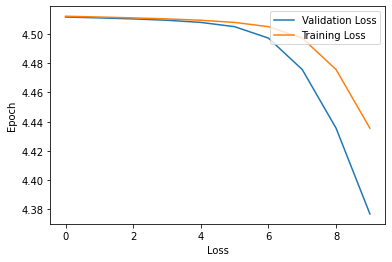

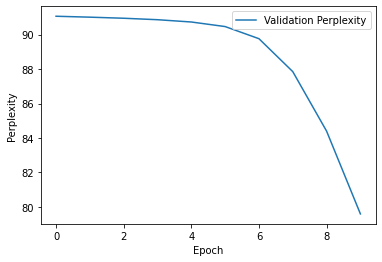

καιρ·:a2-υη%φ


In [ ]:
import random
import matplotlib.pyplot as plt

val_lossList = list()
train_lossList = list()
valPerplexityLSTM = list()
def evaluate(genereator,model,x_val,y_val,bz):
    val_loss = 0
    with torch.no_grad():
        hidden,cell = genereator.NetLSTM.init_hidden(batch_size = bz)
        for c in range(genereator.chunk_len):
            output, (hidden,cell) = genereator.NetLSTM(x_val[:,c],hidden,cell)
            val_loss += genereator.lossFunc(output,y_val[:,c])
        val_loss = val_loss.item()/genereator.chunk_len
    return val_loss
class Generator():
  def __init__(self):
      self.chunk_len = 128 #no Of chars
      self.num_epochs = 10
      self.batch_size = 1
      self.print_every = 1
      self.hidden_size = 128
      self.num_layers = 10
      self.lr = 0.001
  def char_To_tensor(self,stringValue):
      tensor = torch.zeros(len(stringValue)).long()
      # print(stringValue)
      for c in range(len(stringValue)-1):
          chars = list(stringValue[c])
          for i in chars:
              # print(i)
              tensor[c] = char_to_idx[i]
      return tensor

  def get_batch(self,data):
      start = random.randint(0,len(data)- self.chunk_len)
      end = start + self.chunk_len + 1
      text = data[start:end]
      input = torch.zeros(self.batch_size,self.chunk_len)
      target = torch.zeros(self.batch_size,self.chunk_len)
      for idx in range(self.batch_size):
          input[idx,:] = self.char_To_tensor(text[:-1])
          target[idx,:] = self.char_To_tensor(text[1:])
      return input.long(), target.long()


  def createPlot(self,valLoss,trainLoss):
      plt.plot(range(self.num_epochs),valLoss,label = 'Validation Loss')
      plt.plot(range(self.num_epochs),trainLoss,label = 'Training Loss')
      plt.legend(loc='upper right')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.show()
  def showPerplexity(self,perplexities):
      plt.plot(range(self.num_epochs),perplexities,label = 'Validation Perplexity')
      plt.legend(loc='upper right')
      plt.xlabel('Epoch')
      plt.ylabel('Perplexity')
      plt.show()
  def train(self):
    ppl_min = np.inf
    self.NetLSTM = NetLSTM(len(char_to_idx), self.hidden_size, self.num_layers,len(char_to_idx)).to(device)
    lossFunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.NetLSTM.parameters(), lr=0.001)

    for epoch in range(1,self.num_epochs +1):
        input, target = self.get_batch(X_train)
        inputVal, targetVal = self.get_batch(X_val)
        hidden,cell = self.NetLSTM.init_hidden(batch_size = self.batch_size)
        self.NetLSTM.zero_grad()
        train_loss = 0
        input = input.to(device)
        target = target.to(device)
        inputVal = input.to(device)
        targetVal = target.to(device)
        for c in range(self.chunk_len):
            output, (hidden,cell) = self.NetLSTM(input[:,c],hidden,cell)
            train_loss += lossFunc(output,target[:,c])
        train_loss.backward()
        optimizer.step()
        train_loss = train_loss.item()/self.chunk_len
        # if epoch % self.print_every == 0:
        #     print(f'Train Loss: {train_loss}')

        val_loss = evaluate(self,self.NetLSTM, inputVal,targetVal,self.batch_size)
        ppl = math.exp(val_loss)

        if ppl <= ppl_min:
            is_best = " (best) "
            # print(f1_val)
            torch.save(self.NetLSTM.state_dict(), "model.pt")
            ppl_min = ppl
        else:
            is_best = ""
        valPerplexityLSTM.append(math.exp(val_loss))
        print(f'Epoch {epoch} - Training loss {train_loss:.5f} - | Train. PPL: {math.exp(train_loss):7.3f} | Val. PPL: {math.exp(val_loss):7.3f}')
        val_lossList.append(val_loss)
        train_lossList.append(train_loss)
    self.createPlot(val_lossList,train_lossList)
    self.showPerplexity(valPerplexityLSTM)
def generateText(generator,initString = 'και', pred_len = 10):
      model = NetLSTM(len(char_to_idx), generator.hidden_size, generator.num_layers,len(char_to_idx))
      model.load_state_dict(torch.load('model.pt'))
      hidden,cell = model.init_hidden(batch_size=generator.batch_size)
      init_input = generator.char_To_tensor(initString)
      predicted = initString

      for p in range(len(initString)-1):
          _,(hidenn,cell) = model(init_input[p].view(1).to(device),hidden,cell)
      
      prev_char = init_input[-1]
      for p in range(pred_len):
          out,(hidenn,cell) = model(prev_char.view(1).to(device),hidden,cell)
          # print(cell)
          outputProbs = out.data.view(-1)
          bestNextChar =  torch.multinomial(outputProbs,1)[0]
          predictedChar = idx_to_char[bestNextChar.item()]
          
          predicted += predictedChar
          prev_char = generator.char_To_tensor(predictedChar)

      print(predicted)
gen = Generator()
gen.train()

generateText(gen)
